In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms

from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os


class customImageFolderDataset(Dataset):
    """Custom Image Loader dataset."""
    def __init__(self, dirname, transform=None):
        """
        Args:
            root (string): Path to the images organized in a particular folder structure.
            transform: Any Pytorch transform to be applied
        """
        
        # initalise image paths
        self.image_paths = []
        
        # initialse image labels
        self.labels = []
        
        # get all team folders
        teams = [f.name for f in os.scandir(dirname) if f.is_dir()]

        # iterate over each team folder
        for team in list(teams):

            # create team directory
            teams_dir = os.path.join(dirname,team)

            # get all players for that team
            players = [f.name for f in os.scandir(teams_dir) if f.is_dir()]

            # iterate over each player
            for player in list(players):

                # create player directory
                player_dir = os.path.join(dirname,team,player)

                # get all images for that player
                images = [f.name for f in os.scandir(player_dir)]

                # iterate over all images
                for image in images:

                    # append image path
                    self.image_paths.append(os.path.join(dirname,team,player,image))
                    
                    # append labels
                    self.labels.append(team)


                
        #self.image_paths = glob(f"{root}/*/*")
        print(len(self.image_paths))
        # Get the labels from the image paths
        # self.labels = [x.split("/")[-2] for x in self.image_paths]
        # Create a dictionary mapping each label to a index from 0 to len(classes).
        self.label_to_idx = {x:i for i,x in enumerate(set(self.labels))}
        self.idx_to_label = {ind: label for label, ind in self.label_to_idx.items()}
        self.transform = transform
        
    def __len__(self):
        # return length of dataset
        return len(self.image_paths)
      
    def __getitem__(self, idx):
        # open and send one image and label
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image,self.label_to_idx[label]

In [3]:
traindir = 'part1'
t = transforms.ToTensor()
train_dataset = customImageFolderDataset(dirname=traindir,transform=t)

2636


In [4]:
# set targets
targets = train_dataset.labels

def get_target_counts(targets):
    # count instances of each class in targets
    return {target_class: targets.count(target_class) for target_class in set(targets)}


def print_target_counts(targets):
    target_counts = get_target_counts(targets)
    total_targets = 0
    for target in target_counts:
        total_targets += target_counts[target]
    for target in target_counts:
        print('{}, : {}, {:.1f}%'.format(target,target_counts[target],100*target_counts[target]/total_targets))
        
print('Number of instances in each class of whole dataset:')
print_target_counts(targets)

Number of instances in each class of whole dataset:
middlesbrough, : 319, 12.1%
nottingham_forrest, : 384, 14.6%
spal_team_b, : 66, 2.5%
wigan, : 331, 12.6%
bristol, : 1377, 52.2%
spal_team_a, : 159, 6.0%


In [5]:
# Split data into train 70%, validation 20% and test 10%
# Use stratify to ensure equal weighting of each class
# First split into train and the rest
train_idx, rest_idx = train_test_split(np.arange(len(targets)),test_size=0.3, random_state=42, 
                                        shuffle=True, stratify=targets)

train_targets = [targets[i] for i in train_idx]
rest_targets = [targets[i] for i in rest_idx]

# next split rest into validation and test
valid_idx, test_idx = train_test_split(np.arange(len(rest_targets)),test_size=0.33, random_state=42, 
                                        shuffle=True, stratify=rest_targets)

# refer valid_idx and test_idx back to rest_idx
valid_idx = rest_idx[valid_idx]
test_idx = rest_idx[test_idx]


valid_targets = [targets[i] for i in valid_idx]
test_targets = [targets[i] for i in test_idx]

In [6]:
print('Number of instances in each class of TRAIN dataset:')
print_target_counts(train_targets)
print('\n')
print('Number of instances in each class of VALID dataset:')
print_target_counts(valid_targets)
print('\n')
print('Number of instances in each class of TEST dataset:')
print_target_counts(test_targets)

Number of instances in each class of TRAIN dataset:
middlesbrough, : 223, 12.1%
nottingham_forrest, : 269, 14.6%
spal_team_b, : 46, 2.5%
wigan, : 232, 12.6%
bristol, : 964, 52.2%
spal_team_a, : 111, 6.0%


Number of instances in each class of VALID dataset:
middlesbrough, : 64, 12.1%
nottingham_forrest, : 77, 14.6%
spal_team_b, : 14, 2.6%
wigan, : 66, 12.5%
bristol, : 276, 52.2%
spal_team_a, : 32, 6.0%


Number of instances in each class of TEST dataset:
middlesbrough, : 32, 12.2%
nottingham_forrest, : 38, 14.5%
spal_team_b, : 6, 2.3%
wigan, : 33, 12.6%
bristol, : 137, 52.3%
spal_team_a, : 16, 6.1%


In [7]:
print("Number of training samples: ", len(train_idx))
print(len(valid_idx))
print(len(test_idx))

Number of training samples:  1845
529
262


In [8]:
sample = next(iter(train_dataset))

In [9]:
len(sample)

2

In [10]:
image, label = sample

In [11]:
label

4

In [12]:
image.size()

torch.Size([3, 224, 224])

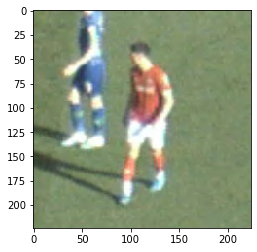

In [13]:
plt.figure()

plt.imshow(image.squeeze().permute(1,2,0))

In [14]:
train_dataloader = DataLoader(train_dataset,batch_size = 64, shuffle=True)

In [29]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(train_dataset, sampler=test_sampler)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(6 * 112 * 112, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1,6 * 112 * 112)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [17]:
criterion = nn.CrossEntropyLoss()

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):

    total_loss = 0
    total_correct = 0
    
    model.train()
    
    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = model(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    
    model.eval()
    
    val_total_loss = 0
    val_total_correct = 0
    
    for val_batch in valid_loader:
        val_images, val_labels = val_batch
        val_pred = model(val_images)
        val_loss = F.cross_entropy(val_pred, val_labels)
        val_total_loss += val_loss.item()
        val_total_correct += get_num_correct(val_pred,val_labels)
        
    print(
        'epoch: {},'.format(epoch), 
        'total_correct:{},'.format(total_correct), 
        'loss: {:.1f},'.format(total_loss),
        'validation_total_correct: {}'.format(val_total_correct),
        'validation_loss: {:.1f},'.format(val_total_loss)

    )

epoch: 0, total_correct:804, loss: 158.0, validation_total_correct: 276 validation_loss: 14.6,
epoch: 1, total_correct:964, loss: 42.8, validation_total_correct: 276 validation_loss: 12.4,
epoch: 2, total_correct:969, loss: 39.2, validation_total_correct: 284 validation_loss: 12.0,
epoch: 3, total_correct:1025, loss: 36.6, validation_total_correct: 302 validation_loss: 10.9,
epoch: 4, total_correct:1083, loss: 32.4, validation_total_correct: 313 validation_loss: 9.6,
epoch: 5, total_correct:1188, loss: 26.9, validation_total_correct: 345 validation_loss: 7.9,
epoch: 6, total_correct:1342, loss: 22.4, validation_total_correct: 370 validation_loss: 8.6,
epoch: 7, total_correct:1378, loss: 20.4, validation_total_correct: 403 validation_loss: 6.4,
epoch: 8, total_correct:1486, loss: 16.5, validation_total_correct: 408 validation_loss: 5.8,
epoch: 9, total_correct:1514, loss: 16.4, validation_total_correct: 414 validation_loss: 6.3,


In [20]:
test_total_loss = 0
test_total_correct = 0
test_predictions = []
test_targets = []

for test_batch in test_loader:
    test_image, test_label = batch
    test_pred = model(test_image)
    test_predictions.append(test_pred.argmax(dim=1))
    test_targets.append(test_label)
    test_loss = F.cross_entropy(test_pred, test_label)
    test_total_loss += test_loss.item()
    test_total_correct += get_num_correct(test_pred,test_label)

In [27]:
test_image.size()

torch.Size([53, 3, 224, 224])

In [21]:
test_prediction_labels = [train_dataset.idx_to_label[p.item()] for p in test_predictions]
test_target_labels = [train_dataset.idx_to_label[p.item()] for p in test_targets]

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
test_prediction_labels

In [ ]:
test_target_labels

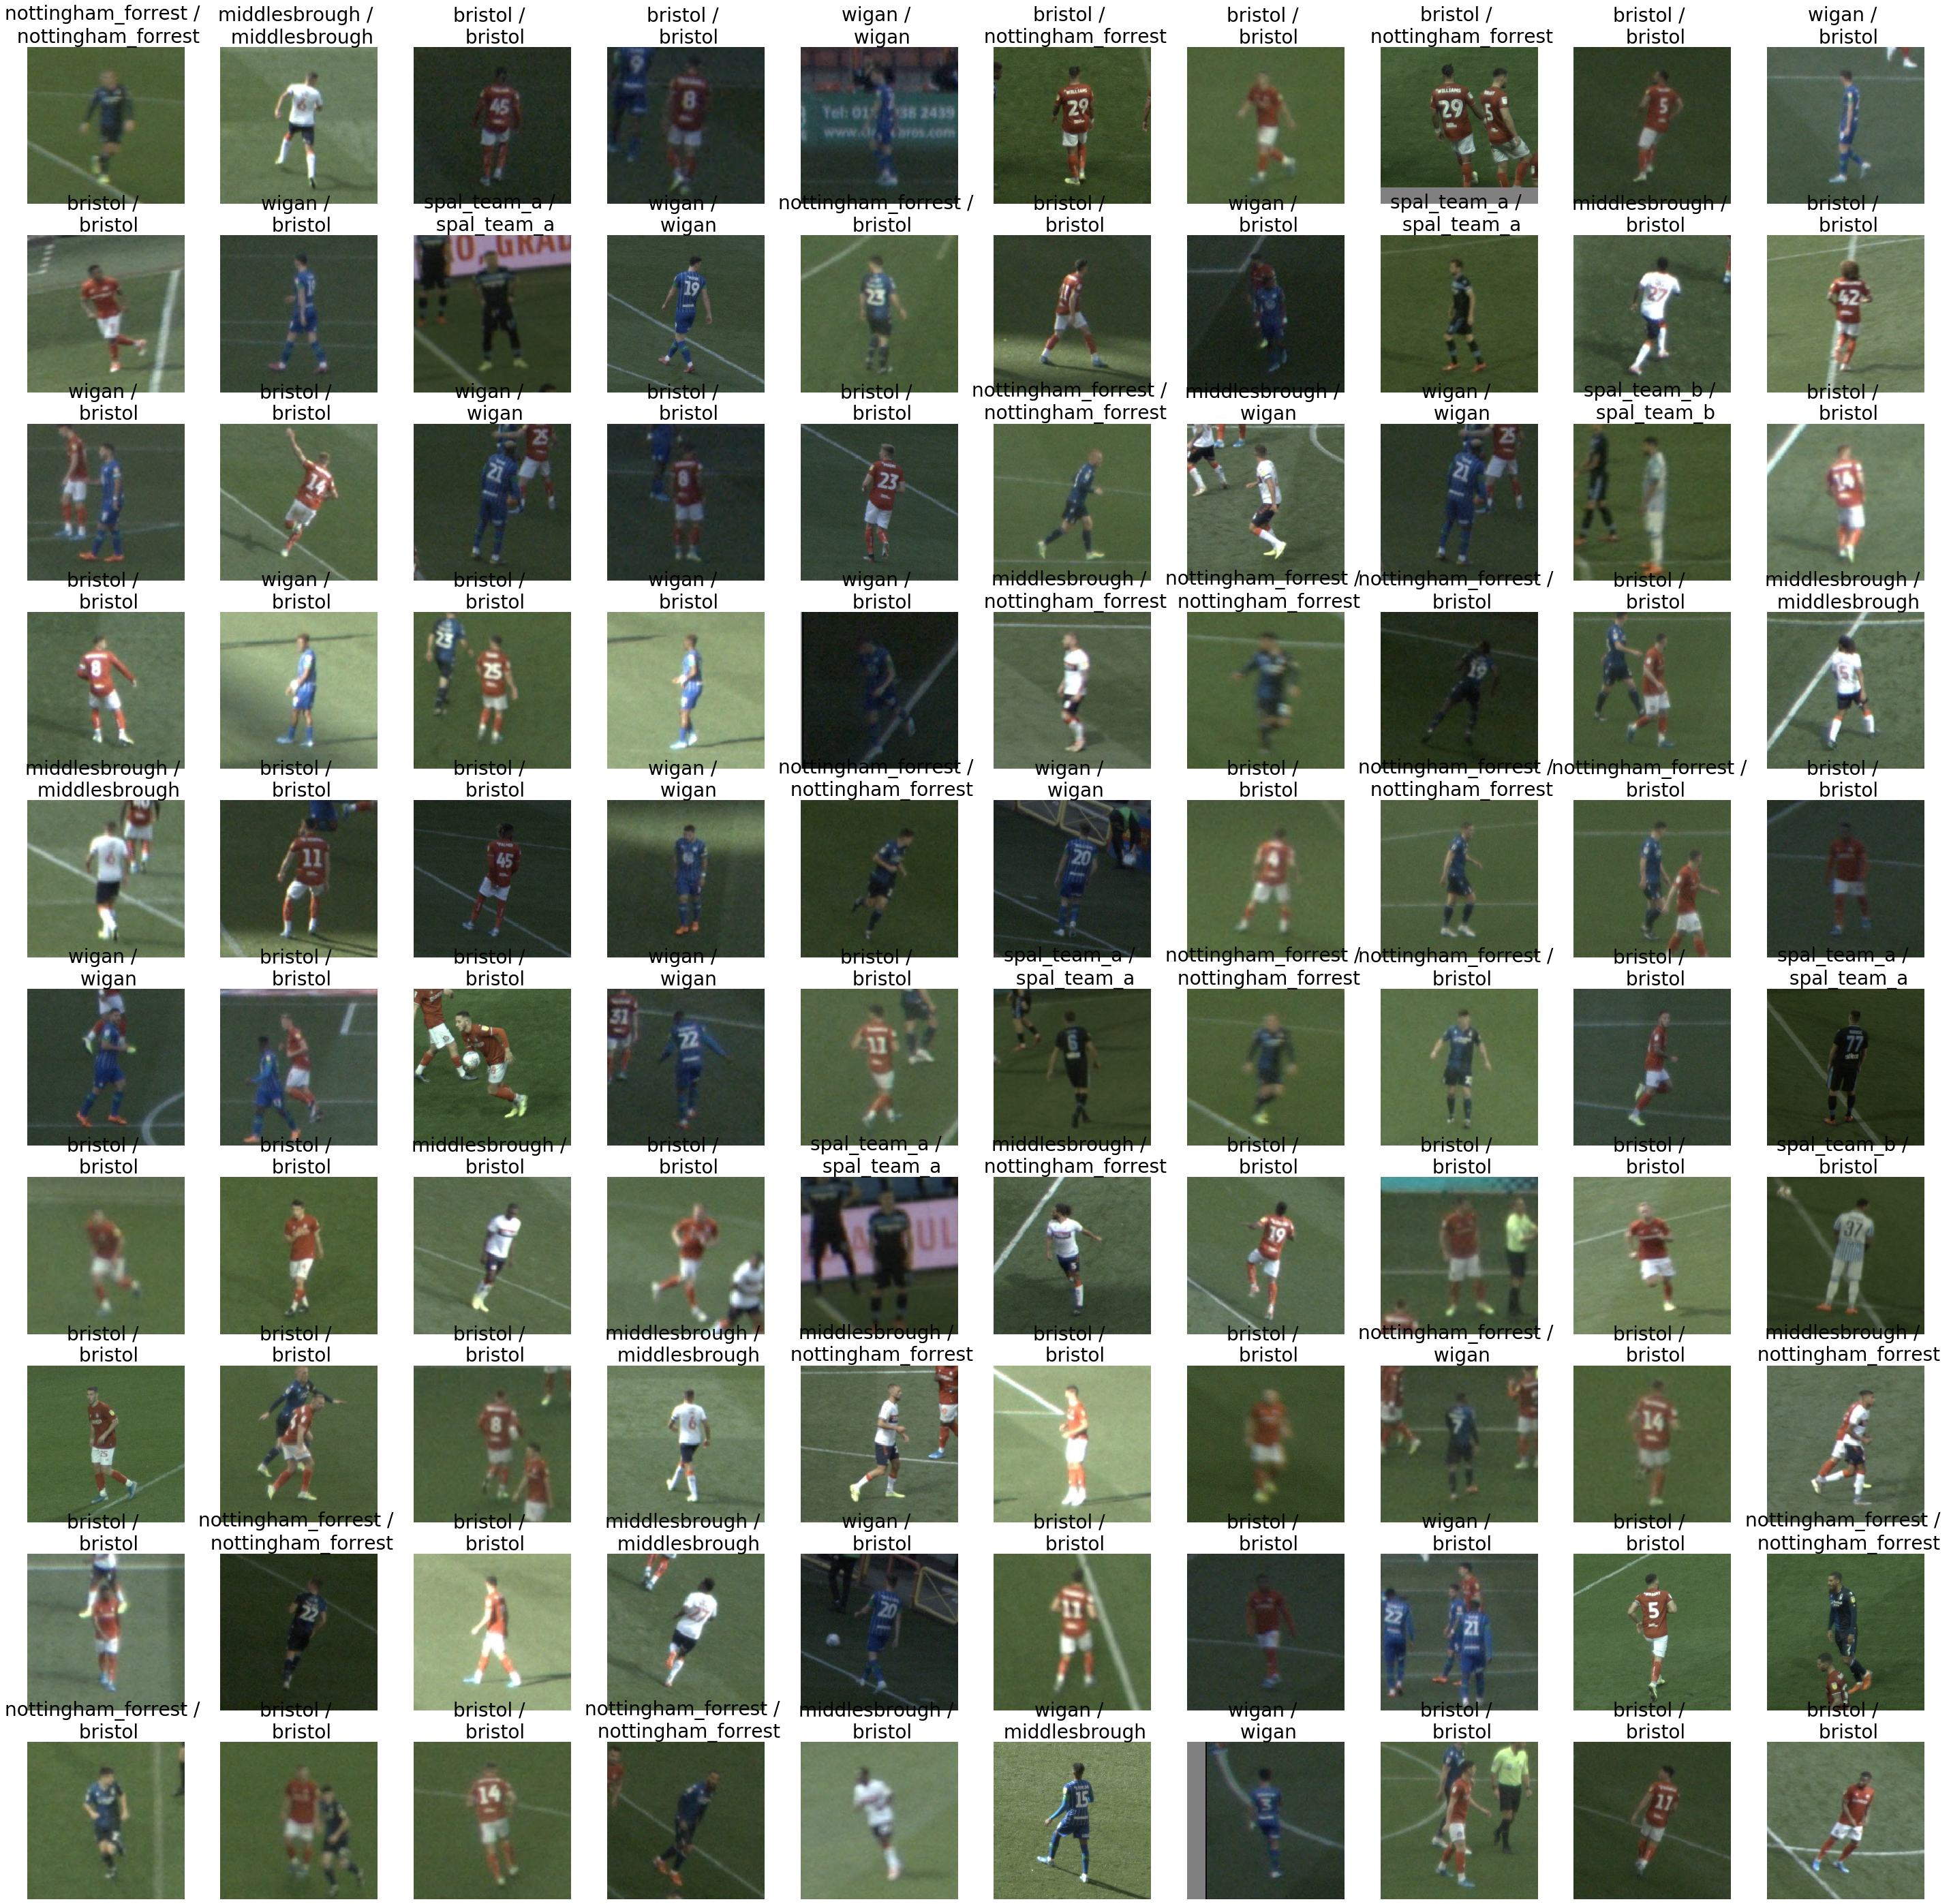

In [33]:
how_many_to_plot = 100
plt.figure(figsize=(50,50))
i = 0
for i, [image,label] in enumerate(test_loader):
    plt.subplot(10,10,i+1)
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.axis('off')
    
    test_pred_idx = model(image).argmax(dim=1)
    test_pred_label = train_dataset.idx_to_label[test_pred_idx.item()]
    
    imtitle = train_dataset.idx_to_label[label.item()] + ' / \n ' +  test_pred_label
    plt.title(imtitle, fontsize=28)
    if (i >= how_many_to_plot-1): break
plt.show()

In [ ]:
label.item()

In [ ]:
i

In [47]:

# saving model
example_im, example_label  = next(iter(test_loader))

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_im)

In [39]:
example_im.size()

torch.Size([3, 224, 224])

In [41]:
image.size()

torch.Size([1, 3, 224, 224])

In [43]:
subset_indices = [0] # select your indices here as a list

subset = torch.utils.data.Subset(train_dataset, subset_indices)

testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

In [45]:
inputs, classes = next(iter(test_loader))

In [46]:
inputs.size()

torch.Size([1, 3, 224, 224])

In [48]:
output = traced_script_module(example_im)

In [49]:
output

tensor([[ -7.2154,  18.4875, -61.4526, -17.3329, -10.5598,  39.0181]],
       grad_fn=<AddBackward0>)

In [50]:
traced_script_module.save("team_model.pt")